# **Analyze Kaggle In Kaggle**
In this extra credit assignment, you will explore the [Kaggle dataset transformed from real Kaggle databases](
https://www.kaggle.com/datasets/kaggle/meta-kaggle).
You will be asked to write four queries for data analysis over two types of datasets (normalized vs. denormalized). You need to fill out the survey questions. We grade queries based on correctness, and survey questions based on efforts.

In [ ]:
#@title Please fill in the form and run the cell by clicking on the left run button (circle with a triangle play icon) { run: "auto", vertical-output: true, display-mode: "form" }

#@markdown What's your years of experience in SQL?
SQL_yoe = "unselected - Please select!!" #@param ["unselected - Please select!!"," < 3 months", "3 months - 1 year", "1 - 3 years", "> 3 years"]

#@markdown Fill in your uni here:
uni = "" #@param {type:"string"}
assert uni != "", "Please fill in your uni!"

%pip install duckdb

from IPython.display import Markdown as md
import urllib.request
import duckdb
import numpy as np
import math
def convertToNumber (s):
    return int.from_bytes(s.encode(), 'little')


urllib.request.urlretrieve("https://raw.githubusercontent.com/zachary62/wide-table-data/main/kaggle/Competitions.csv", "Competitions.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/zachary62/wide-table-data/main/kaggle/Users.csv", "Users.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/zachary62/wide-table-data/main/kaggle/TeamMemberships.csv", "TeamMemberships.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/zachary62/wide-table-data/main/kaggle/Teams.csv", "Teams.csv")

seed = convertToNumber(uni) % 100000
np.random.seed(seed)
qidx = np.random.permutation(4)
qnor = np.random.permutation([True, False])

query = []
query.append("""
Find the total number of teams participating in the competition **NOT** hosted by 'UCL' (as HostName).

The output schema should be: [TotalTeams].
""")

query.append("""
A ghost team is a team without any User as its member.

Compute the total number of competitions participated by any ghost team.

The output schema should be: [TotalCompetition].
""")


query.append("""
For each team leader whose RegisterDate is before 2012-1-1, compute the average TeamPublicLeaderboardRank for all teams he or she leads.

For date, it is okay to use string comparison (< '2012-1-1').

Please disregard any team with missing (NULL) TeamPublicLeaderboardRank.

The output schema should be: [TeamLeaderId, AverageRank].
""")


query.append("""
For competitions where there exists participant User with UserPerformanceTier = 5, compute the total duration across all these competitions.

The output should be a single record of the total duration.

The output schema should be: [TotalDuration].
""")

normalized = """
For this task, you are asked to analyze the original normalized Kaggle dataset.

The database is **the same** as that from the Background before. For reference, we copy the schema below:

(the primay key is in bold and the foreign key is in italic)

* **Users**: [**'UserId'**, 'UserDisplayName', 'UserName', 'UserPerformanceTier', 'UserRegisterDate']
* **Competitions**: [**'CompetitionId'**, 'CompetitionDeadlineDate', 'CompetitionDuration', 'CompetitionEnabledDate', 'CompetitionHostName', 'CompetitionHostSegmentTitle', 'CompetitionSlug', 'CompetitionSubtitle', 'CompetitionTitle']
* **Teams**: [**'TeamId'**, *'CompetitionId'*, *'TeamLeaderId'*, 'TeamLastSubmissionDate', 'TeamMedal', 'TeamMedalAwardDate', 'TeamName', 'TeamPublicLeaderboardRank']
* **TeamMemberships**: [**'MembershipId'**, *'TeamId'*, *'UserId'*, 'MembershipRequestDate']

Answer the following two questions and surveys based on **these four normalized datasets**:
"""

denormalized = """
For this task, you are asked to analyze only using the denormalized Kaggle relation.

The denormalized Kaggle relation is computed through full outer join from the original normalized database.

The schema of the denormalized relation is as follows:

**kaggle_dataset** ['CompetitionId', 'CompetitionTitle', 'CompetitionHostName',
       'CompetitionHostSegmentTitle', 'CompetitionDuration', 'TeamId',
       'TeamName', 'TeamMedal', 'TeamLastSubmissionDate',
       'TeamPublicLeaderboardRank', 'TeamLeaderId', 'TeamLeaderUserName',
       'TeamLeaderRegisterDate', 'UserId', 'UserName', 'UserPerformanceTier',
       'UserRegisterDate']


- Attributes for Competitions are prefixed with Competition: ['CompetitionId', 'CompetitionTitle', 'CompetitionHostName',
       'CompetitionHostSegmentTitle', 'CompetitionDuration']
- Attributes for Teams are prefixed with Team: ['TeamId','TeamName', 'TeamMedal', 'TeamLastSubmissionDate', 'TeamPublicLeaderboardRank']
- Attributes for Team Leader are prefixed with TeamLeader: ['TeamLeaderId', 'TeamLeaderUserName',
       'TeamLeaderRegisterDate']
- Attributes for Team Members are prefixed with User: ['UserId', 'UserName', 'UserPerformanceTier', 'UserRegisterDate']

Answer the following two questions and surveys based on **the denormalized kaggle_dataset**:
"""

In [ ]:
#@title Consent Form { run: "auto", vertical-output: true, display-mode: "form" }
#@markdown **Purpose of this study:**We hope to use assignment submissions as part of a research study. The purpose of this study is to understand how easy or difficult it is to write correct analysis queries over normalized and denormalized databases.  This will help us understand challenges in database decomposition, and inform the development of simpler and more correct querying interfaces. If you have any questions about the study, please reach out to Zachary Huang (zh2408@columbia.edu).

#@markdown **Freedom to withdraw:** Your choice to participate in this study is completely voluntary and does not affect your extra credit grade.  If you want to withdraw your consent in the future, please contact Zachary Huang. We will destroy any data we hold from you.

#@markdown **Privacy & Data Security:** We will ask you to write SQL queries using normalized and denormalized databses, and fill out surveys. We do not collect any other personal information and the data are anonymous. We will carefully examine the words and exclude any details that may contain identifiable information.  Identifying information involved during recruitment (uni) will not be stored for the study. We may publish research reports that include your comments and actions, but they will be anonymous.

#@markdown If you are below 18, we will not use your data. 

#@markdown **If you are over 18 and are willing to participate in the study, please answer yes. If you are below 18 or decline to participate in the study, please answer no.** 
consent = "yes" #@param ["yes","no"]



# **Background**

Here, we introduce some important entities in Kaggle for this assignment.

*  [**User**](https://www.kaggle.com/rankings): Kaggle has many Users. Each User has UserName, RegisterDate and PerformanceTier. 

*  [**Competitions**](https://www.kaggle.com/competitions): Kaggle has many competitions hosted by different entities. Each competition has a fixed Duration.

*  **Teams**: Users form a team to participate in one competition. Check out [the example teams and leaderboard](https://www.kaggle.com/competitions/feedback-prize-english-language-learning/leaderboard) for one competition. Each Team could have a Team Leader and many members. Each Team submits to the competition and the best teams win medals. 

# **Database**

We use DuckDB for this assignment. Check out the DuckDB tutorial [here](https://duckdb.org/docs/sql/introduction).

The original Kaggle database has four relations (the primary key is in bold and the foreign key is in italic):

* **Users**: [**'UserId'**, 'UserDisplayName', 'UserName', 'UserPerformanceTier', 'UserRegisterDate']
* **Competitions**: [**'CompetitionId'**, 'CompetitionDeadlineDate', 'CompetitionDuration', 'CompetitionEnabledDate', 'CompetitionHostName', 'CompetitionHostSegmentTitle', 'CompetitionSlug', 'CompetitionSubtitle', 'CompetitionTitle']
* **Teams**: [**'TeamId'**, *'CompetitionId'*, *'TeamLeaderId'*, 'TeamLastSubmissionDate', 'TeamMedal', 'TeamMedalAwardDate', 'TeamName', 'TeamPublicLeaderboardRank']
* **TeamMemberships**: [**'MembershipId'**, *'TeamId'*, *'UserId'*, 'MembershipRequestDate']

The following ER diagram shows the relationships among entities:
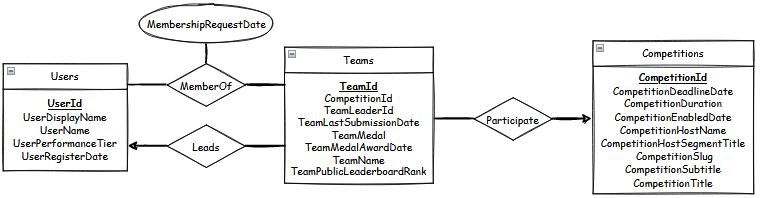

- Each team has multiple Users, and each User can be in multiple teams. The 'TeamMemberships' relation is used to represent the many-to-many relationship.
- Each team has at most one User as the team leader.
- Each team participates in at most one competition.


In [ ]:
#@title Task 1. Please run the cell for task details (click on the left run button){ vertical-output: true, display-mode: "form" }
con = duckdb.connect(database=':memory:')
if qnor[0]:
  con.execute("CREATE OR REPLACE TABLE Competitions AS SELECT * FROM Competitions.csv;")
  con.execute("CREATE OR REPLACE TABLE Users AS SELECT * FROM Users.csv;")
  con.execute("CREATE OR REPLACE TABLE TeamMemberships AS SELECT * FROM TeamMemberships.csv;")
  con.execute("CREATE OR REPLACE TABLE Teams AS SELECT * FROM Teams.csv;")
else:
  con.execute("CREATE OR REPLACE TABLE Competitions AS SELECT * FROM Competitions.csv;")
  con.execute("CREATE OR REPLACE TABLE Users AS SELECT * FROM Users.csv;")
  con.execute("CREATE OR REPLACE TABLE TeamMemberships AS SELECT * FROM TeamMemberships.csv;")
  con.execute("CREATE OR REPLACE TABLE Teams AS SELECT * FROM Teams.csv;")
  con.execute("""
  CREATE OR REPLACE TABLE kaggle_dataset AS
  SELECT c.CompetitionId, c.CompetitionTitle, c.CompetitionHostName, c.CompetitionHostSegmentTitle, c.CompetitionDuration, 
  t.TeamId, t.TeamName, t.TeamMedal, t.TeamLastSubmissionDate, t.TeamPublicLeaderboardRank,
  t.TeamLeaderId, lu.UserName AS TeamLeaderUserName, lu.UserRegisterDate AS TeamLeaderRegisterDate,
  u.UserId, u.UserName, u.UserPerformanceTier, u.UserRegisterDate,
  FROM Teams t FULL JOIN Competitions c ON c.CompetitionId = t.CompetitionId 
  FULL JOIN Users lu ON lu.UserId = t.TeamLeaderId
  FULL JOIN TeamMemberships tm ON tm.TeamId = t.TeamId
  FULL JOIN Users u ON u.UserId = tm.UserId;
  """)
  con.execute("DROP TABLE Teams;")
  con.execute("DROP TABLE Competitions;")
  con.execute("DROP TABLE Users;")
  con.execute("DROP TABLE TeamMemberships;")

md(
(normalized if qnor[0] else denormalized) +
"""
**Question 1:** {q1}
**Question 2:** {q2}
""".format(q1=query[qidx[0]], q2=query[qidx[1]]))

In [ ]:
# Anwer Q1 below (2 points based on correctness)
q1 = """SELECT 1"""
con.execute(q1).df()

In [ ]:
#@title Q1 survey (1 point based on efforts) { run: "auto", display-mode: "form" }
#@markdown **Please fill in the survey and run the cell (by clicking on the run button to the left)**

#@markdown How confident do you feel about the correctness of the query?
q1_confidence = "unselected - Please select!!" #@param ["unselected - Please select!!","1 (Very confident)", "2 (somehow confident)", "3 (neutral)", "4 (somehow unconfident)", "5 (very unconfident)"]
#@markdown How easy is the process of constructing the query?
q1_preference = "unselected - Please select!!" #@param ["unselected - Please select!!","1 (Very easy)", "2 (somehow easy)", "3 (neutral)", "4 (somehow frustrating)", "5 (very frustrating)"]

#@markdown During the process of composing the query, what were the parts frustrating or challenging? Please elaborate in a few words.
q1_review = "" #@param {type:"string"}


In [ ]:
# Answer Q2 below (2 points based on correctness)
q2 = """SELECT 1"""
con.execute(q2).df()

In [ ]:
#@title Q2 survey (1 point based on efforts) { run: "auto", display-mode: "form" }
#@markdown **Please fill in the survey and run the cell (by clicking on the run button to the left)**

#@markdown How confident do you feel about the correctness of the query?
q2_confidence = "unselected - Please select!!" #@param ["unselected - Please select!!","1 (Very confident)", "2 (somehow confident)", "3 (neutral)", "4 (somehow unconfident)", "5 (very unconfident)"]
#@markdown How easy is the process of constructing the query?
q2_preference = "unselected - Please select!!" #@param ["unselected - Please select!!","1 (Very easy)", "2 (somehow easy)", "3 (neutral)", "4 (somehow frustrating)", "5 (very frustrating)"]

#@markdown During the process of composing the query, what were the parts frustrating or challenging? Please elaborate in a few words.
q2_review = "" #@param {type:"string"}


In [ ]:
#@title Task 2. Please run the cell for task details (click on the left run button){ vertical-output: true, display-mode: "form" }
con = duckdb.connect(database=':memory:')
if qnor[1]:
  con.execute("CREATE OR REPLACE TABLE Competitions AS SELECT * FROM Competitions.csv;")
  con.execute("CREATE OR REPLACE TABLE Users AS SELECT * FROM Users.csv;")
  con.execute("CREATE OR REPLACE TABLE TeamMemberships AS SELECT * FROM TeamMemberships.csv;")
  con.execute("CREATE OR REPLACE TABLE Teams AS SELECT * FROM Teams.csv;")
else:
  con.execute("CREATE OR REPLACE TABLE Competitions AS SELECT * FROM Competitions.csv;")
  con.execute("CREATE OR REPLACE TABLE Users AS SELECT * FROM Users.csv;")
  con.execute("CREATE OR REPLACE TABLE TeamMemberships AS SELECT * FROM TeamMemberships.csv;")
  con.execute("CREATE OR REPLACE TABLE Teams AS SELECT * FROM Teams.csv;")
  con.execute("""
  CREATE OR REPLACE TABLE kaggle_dataset AS
  SELECT c.CompetitionId, c.CompetitionTitle, c.CompetitionHostName, c.CompetitionHostSegmentTitle, c.CompetitionDuration, 
  t.TeamId, t.TeamName, t.TeamMedal, t.TeamLastSubmissionDate, t.TeamPublicLeaderboardRank,
  t.TeamLeaderId, lu.UserName AS TeamLeaderUserName, lu.UserRegisterDate AS TeamLeaderRegisterDate,
  u.UserId, u.UserName, u.UserPerformanceTier, u.UserRegisterDate,
  FROM Teams t FULL JOIN Competitions c ON c.CompetitionId = t.CompetitionId 
  FULL JOIN Users lu ON lu.UserId = t.TeamLeaderId
  FULL JOIN TeamMemberships tm ON tm.TeamId = t.TeamId
  FULL JOIN Users u ON u.UserId = tm.UserId;
  """)
  con.execute("DROP TABLE Teams;")
  con.execute("DROP TABLE Competitions;")
  con.execute("DROP TABLE Users;")
  con.execute("DROP TABLE TeamMemberships;")

md(
(normalized if qnor[1] else denormalized) +
"""
**Question 3:** {q3}
**Question 4:** {q4}
""".format(q3=query[qidx[2]], q4=query[qidx[3]]))

In [ ]:
# Answer Q3 below (2 points based on correctness)
q3 = """SELECT 1"""
con.execute(q3).df()

In [ ]:
#@title Q3 survey (1 point based on efforts) { run: "auto", display-mode: "form" }
#@markdown **Please fill in the survey and run the cell (by clicking on the run button to the left)**

#@markdown How confident do you feel about the correctness of the query?
q3_confidence = "unselected - Please select!!" #@param ["unselected - Please select!!","1 (Very confident)", "2 (somehow confident)", "3 (neutral)", "4 (somehow unconfident)", "5 (very unconfident)"]
#@markdown How easy is the process of constructing the query?
q3_preference = "unselected - Please select!!" #@param ["unselected - Please select!!","1 (Very easy)", "2 (somehow easy)", "3 (neutral)", "4 (somehow frustrating)", "5 (very frustrating)"]

#@markdown During the process of composing the query, what were the parts frustrating or challenging? Please elaborate in a few words.
q3_review = "" #@param {type:"string"}


In [ ]:
# Answer Q4 below (2 points based on correctness)
q4 = """SELECT 1"""
con.execute(q4).df()

In [ ]:
#@title Q4 survey (1 point based on efforts) { run: "auto", display-mode: "form" }
#@markdown **Please fill in the survey and run the cell (by clicking on the run button to the left)**

#@markdown How confident do you feel about the correctness of the query?
q4_confidence = "unselected - Please select!!" #@param ["unselected - Please select!!","1 (Very confident)", "2 (somehow confident)", "3 (neutral)", "4 (somehow unconfident)", "5 (very unconfident)"]
#@markdown How easy is the process of constructing the query?
q4_preference = "unselected - Please select!!" #@param ["unselected - Please select!!","1 (Very easy)", "2 (somehow easy)", "3 (neutral)", "4 (somehow frustrating)", "5 (very frustrating)"]

#@markdown During the process of composing the query, what were the parts frustrating or challenging? Please elaborate in a few words.
q4_review = "" #@param {type:"string"}


In [ ]:
#@title Final survey (1 point based on efforts) { run: "auto", display-mode: "form" }
#@markdown **Please fill in the survey and run the cell (by clicking on the run button to the left)**

#@markdown Overall, I find it easier to compose queries
q5_preference = "unselected - Please select!!" #@param ["unselected - Please select!!","1 (always over normalized tables (4 tables))", "2 (more often over normalized tables (4 tables))", "3 (neutral)", "4 (more often over denormalzied table (kaggle_dataset))", "5 (always over denormalzied table (kaggle_dataset))"]

#@markdown Overall, which parts do you find convenient/frustrating while composing queries over normalized and denormalized databases? Please share your opinions.
q5_review = "" #@param {type:"string"}

#@markdown (Optional) If you have any other comments, please share them below:
q5_comment = "" #@param {type:"string"}


# **Submission**
Submit the assignment: Please ensure that the following json text is correct and you have filled in all the surveys. Copy and paste the json text result to gradescope assignment "[Extra Credit] Kaggle Assignment".

In [ ]:
answer = {
    "uni": uni,
    "SQL_yoe": SQL_yoe,

    # Please don't modify below two
    "qidx": qidx,
    "qnor": qnor,

    "consent": consent,

    "q1": q1,
    "q1_confidence":q1_confidence,
    "q1_preference": q1_preference,
    "q1_review": q1_review,

    "q2": q2,
    "q2_confidence":q2_confidence,
    "q2_preference": q2_preference,
    "q2_review": q2_review,

    "q3": q3,
    "q3_confidence":q3_confidence,
    "q3_preference": q3_preference,
    "q3_review": q3_review,

    "q4": q4,
    "q4_confidence":q5_confidence,
    "q4_preference": q4_preference,
    "q4_review": q4_review, 

    "q5_preference": q5_preference,
    "q5_review": q5_review,
    "q5_comment": q5_comment
}

print("copy the following and paste it to gradescope:\n\n",answer)